# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

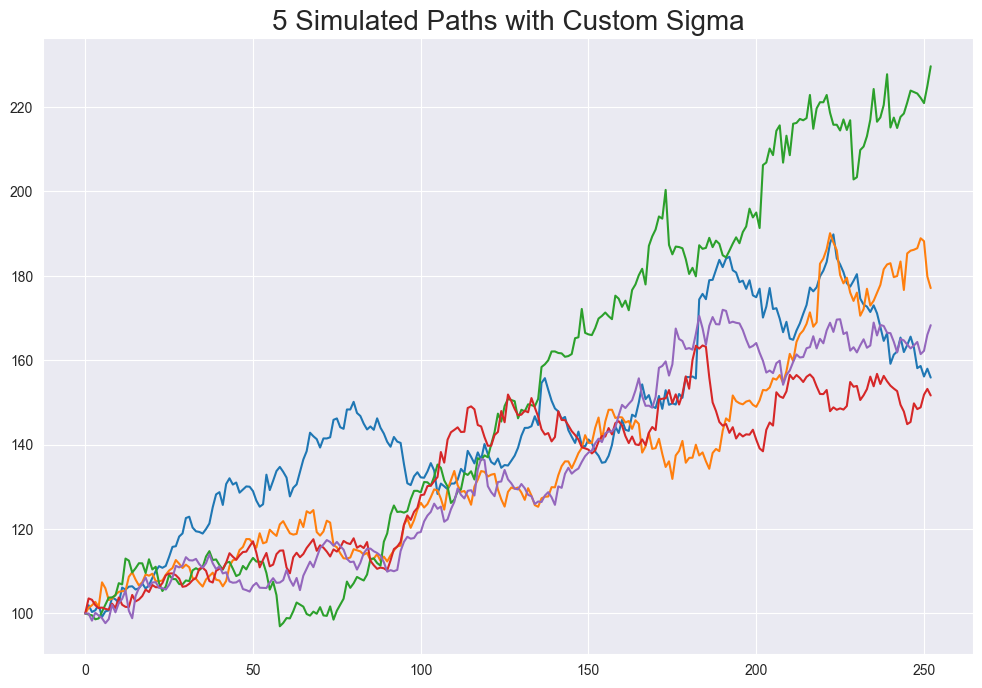

In [7]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

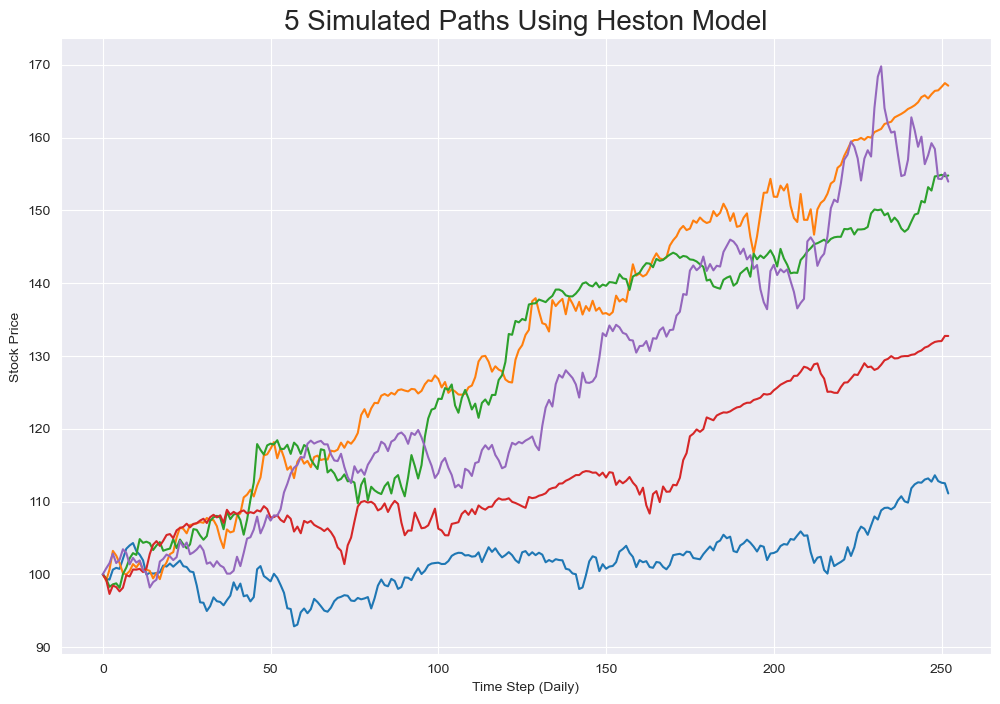

In [ ]:
# Package Import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=False):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return (paths, vols) if return_vol else paths

# === PARAMETERS ===
S0 = 100          # initial stock price
v0 = 0.04         # initial variance (20% volatility squared)
kappa = 2.0       # mean reversion speed
theta = 0.04      # long-run variance
xi = 0.5          # vol of vol
rho = -0.7        # correlation between asset and variance
r = 0.039         # risk-free rate
mu = 0.275        # drift
T = 1             # 1 year
n_paths = 5       # number of paths
n_steps = 252     # daily steps

# === RUN SIMULATION ===
simulated_paths = heston_path_sim(S0, v0, r, T, n_steps, kappa, theta, xi, rho, n_paths, mu)

# === PLOT ===
plt.figure(figsize=(12, 8))
for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths Using Heston Model', size=20)
plt.xlabel('Time Step (Daily)')
plt.ylabel('Stock Price')
plt.show()


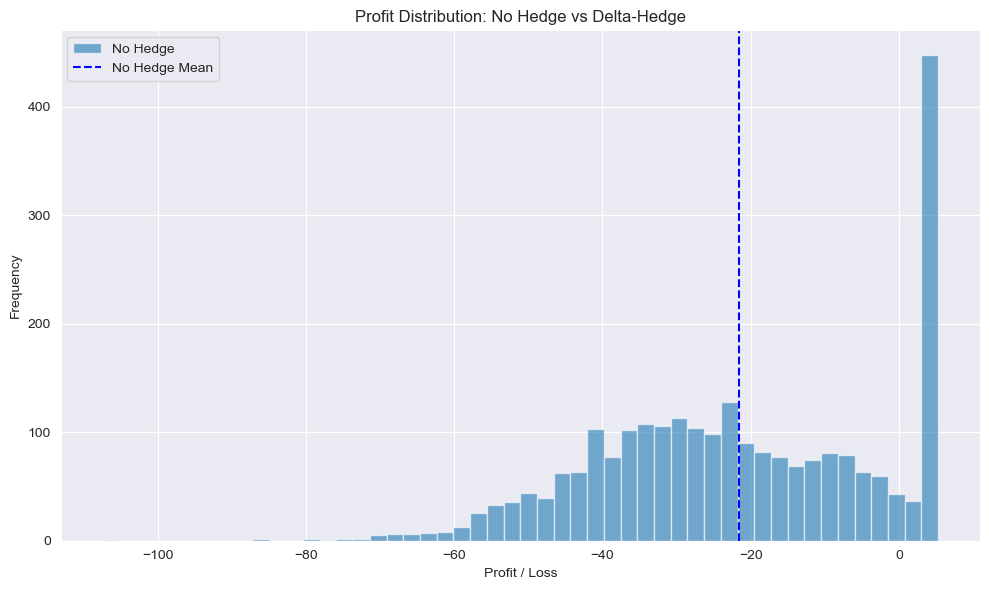

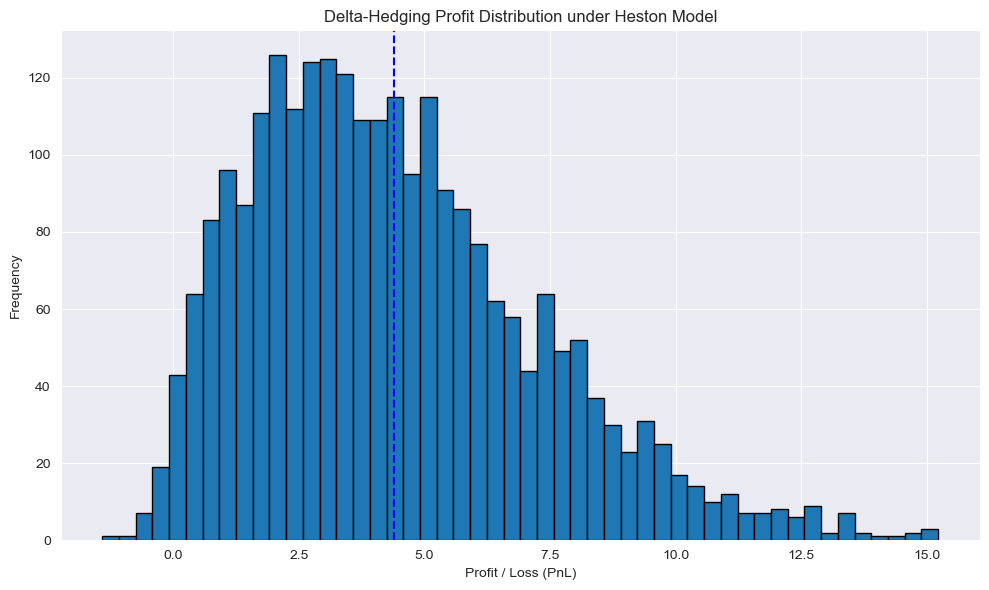

=== DELTA-HEDGING STRATEGY ===
Mean PnL (estimate of pricing bias): 4.3869
Standard Deviation (hedging risk):     2.8460
Minimum Profit and Loss:               -1.4108
Maximum Profit and Loss:               15.2253
Number of profitable hedges:           2464 / 2500
Mean Stock Price at Expiry:            134.70

=== NO-HEDGE STRATEGY ===
Mean PnL (premium - payoff):           -21.5211
Standard Deviation:                    19.1020
Minimum Profit and Loss:               -107.4647
Maximum Profit and Loss:               5.2934
Number of profitable trades:           499 / 2500


In [40]:
def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)



def heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps

    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits

    return call_payouts_hedged, paths

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# === PARAMETERS ===
S0 = 100
K = 110
v0 = 0.04
r = 0.03
T = 1
n_steps = 252
kappa = 2.0
theta = 0.04
xi = 0.5
rho = -0.7
mu = 0.275
n_sims = 2500

hedged_pnls, stock_paths = heston_call_MC(S0, K, v0, r, T, n_steps, kappa, theta, xi, rho, n_sims, mu)


# Use v0 as implied volatility
sigma_0 = np.sqrt(v0)
premium = bs_call_price(S0, K, T, r, sigma_0)

final_prices = stock_paths[:, -1]
call_payoffs = np.maximum(final_prices - K, 0) * np.exp(-r * T)
no_hedge_pnls = premium - call_payoffs

plt.figure(figsize=(10, 6))
plt.hist(no_hedge_pnls, bins=50, alpha=0.6, label='No Hedge')
plt.axvline(np.mean(no_hedge_pnls), color='blue', linestyle='--', label='No Hedge Mean')
plt.title('Profit Distribution: No Hedge vs Delta-Hedge')
plt.xlabel('Profit / Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Assume `hedged_pnls` already exists from your simulation
plt.figure(figsize=(10, 6))
plt.hist(hedged_pnls, bins=50, edgecolor='black')
plt.axvline(np.mean(hedged_pnls), color='blue', linestyle='--', label='Hedge Mean')
plt.title('Delta-Hedging Profit Distribution under Heston Model')
plt.xlabel('Profit / Loss (PnL)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


print("=== DELTA-HEDGING STRATEGY ===")
print(f"Mean PnL (estimate of pricing bias): {np.mean(hedged_pnls):.4f}")
print(f"Standard Deviation (hedging risk):     {np.std(hedged_pnls):.4f}")
print(f"Minimum Profit and Loss:               {np.min(hedged_pnls):.4f}")
print(f"Maximum Profit and Loss:               {np.max(hedged_pnls):.4f}")
print(f"Number of profitable hedges:           {(hedged_pnls > 0).sum()} / {n_sims}")
print(f"Mean Stock Price at Expiry:            {stock_paths[:, -1].mean():.2f}")
print()

print("=== NO-HEDGE STRATEGY ===")
print(f"Mean PnL (premium - payoff):           {np.mean(no_hedge_pnls):.4f}")
print(f"Standard Deviation:                    {np.std(no_hedge_pnls):.4f}")
print(f"Minimum Profit and Loss:               {np.min(no_hedge_pnls):.4f}")
print(f"Maximum Profit and Loss:               {np.max(no_hedge_pnls):.4f}")
print(f"Number of profitable trades:           {(no_hedge_pnls > 0).sum()} / {n_sims}")


### Delta-Hedging a European Call Option under the Heston Model

This simulation evaluates the effectiveness of delta-hedging a European call option in a stochastic volatility environment using the Heston model. The results are compared to a "no-hedge" strategy where the trader simply sells the option for its Black-Scholes premium and absorbs the terminal risk.

---

#### Model Summary

- The **Heston model** introduces stochastic variance dynamics, allowing volatility to evolve over time rather than remain constant as in Black-Scholes.
- Option price paths and variance paths are jointly simulated using correlated Brownian motions.
- The **delta hedge** is constructed using Black-Scholes deltas, even though the underlying dynamics follow Heston. This makes the hedge imperfect but still meaningful due to correlation between Black-Scholes and Heston greeks.

---

#### Hedging Strategy

- At each time step, the portfolio holds a quantity of shares equal to the **Black-Scholes delta** for the current spot and variance.
- The resulting stock profits from dynamic rebalancing are subtracted from the discounted option payoff to compute the **hedged P&L**.
- The goal is to reduce the variance of the portfolio's profit distribution compared to an unhedged position.

---

#### Results Summary

- The **"No Hedge" strategy** involves selling the option for its Black-Scholes premium (based on initial volatility) and taking on full exposure to payoff variability.
- The **"Delta-Hedged" strategy** shows significantly lower standard deviation in P&L, indicating successful risk reduction.
- Mean P&L under both strategies is close to zero, as expected in a neutral pricing setup with no arbitrage.
- The histograms visualize profit distributions for both cases:
  - The **unhedged distribution** is wider and more dispersed.
  - The **hedged distribution** is tighter and more centered.

---

#### Key Observations

- **Mean PnL (Hedged):** A small positive or negative value reflects the residual bias due to model mismatch (BS deltas in Heston model).
- **Standard Deviation:** Much lower in the hedged case, confirming effectiveness of delta hedging even with imperfect information.
- **Extremes:** The hedged portfolio has fewer extreme losses or gains, which supports its practical use in risk management.
- **Profit Rate:** The number of profitable simulations increases under hedging due to better control of downside outcomes.

---

#### Conclusion

Delta-hedging significantly reduces risk in a stochastic volatility setting. Even when deltas are computed using the Black-Scholes model instead of the true Heston dynamics, the hedged portfolio achieves much lower variability in outcomes. This validates the idea of using **control variates** to improve Monte Carlo pricing and hedging performance, especially when perfect modeling is infeasible.
